In [ ]:
!kaggle datasets download -d saurav9786/amazon-product-reviews
!unzip amazon-product-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews
License(s): unknown
 90% 99.0M/109M [00:01<00:00, 69.4MB/s]
100% 109M/109M [00:01<00:00, 76.5MB/s] 
Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


# Import Libraries

In [ ]:
!pip install joblib

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


# Load the Dataset and Add headers

In [ ]:
electronics_data=pd.read_csv("/content/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])


In [ ]:
# Display the data

electronics_data.head()


,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
#Shape of the data
electronics_data.shape

(7824482, 4)

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

,0
userId,object
productId,object
Rating,float64
timestamp,int64


In [ ]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [ ]:
#Five point summary

electronics_data.describe()['Rating'].T


,Rating
count,1.048576e+06
mean,3.973380e+00
std,1.399329e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## Handling Missing values


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


## Ratings

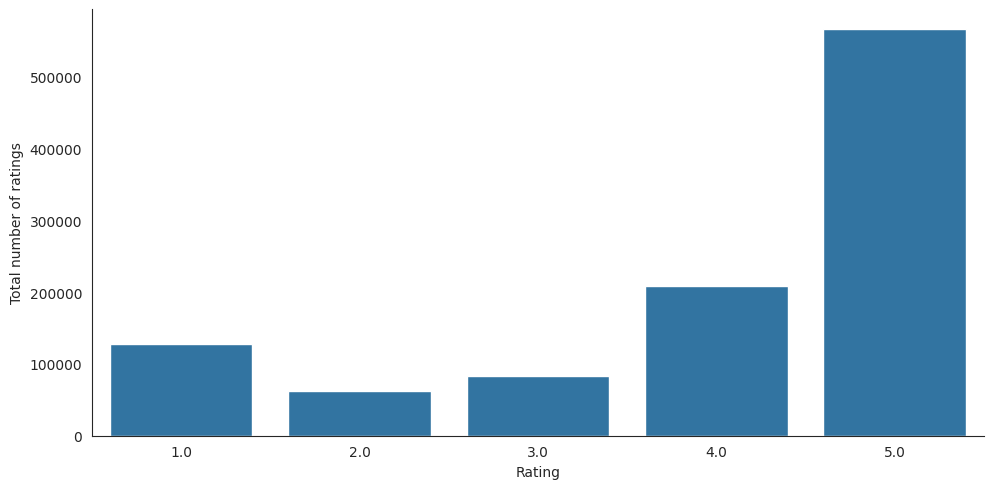

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=electronics_data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

## Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


## Dropping the TimeStamp Column

In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:
#Analysis of rating given by the user

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

,Rating
userId,
A5JLAU2ARJ0BO,412
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,164
A6FIAB28IS79,146
AT6CZDCP4TRGA,128


In [ ]:
no_of_rated_products_per_user.describe()


,Rating
count,786330.000000
mean,1.333506
std,1.385612
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,412.000000


In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

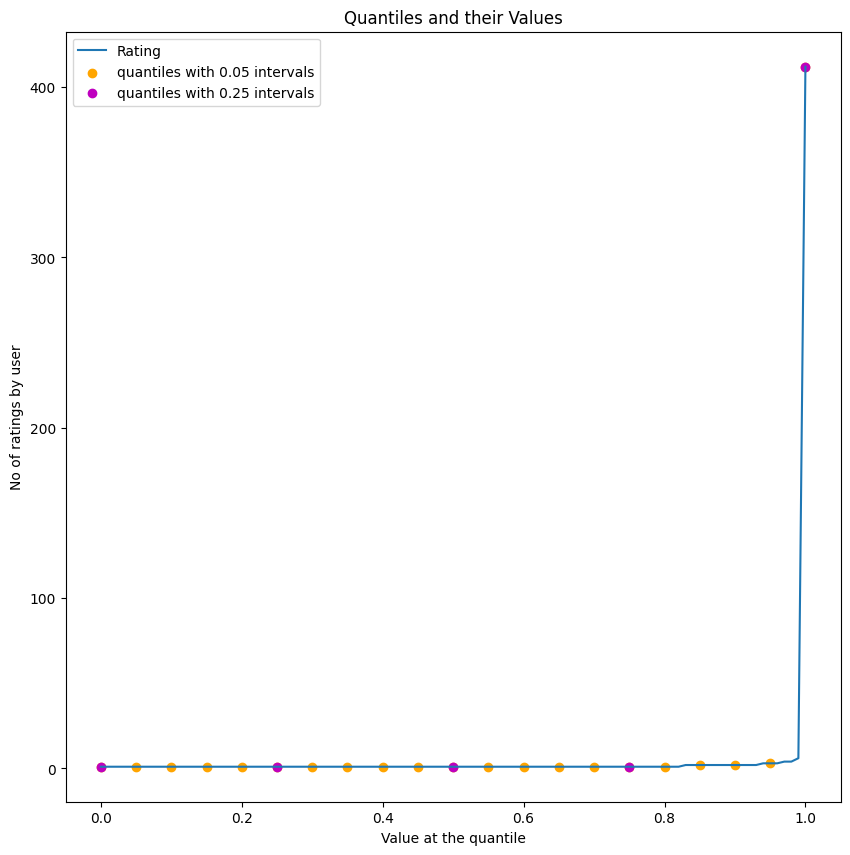

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 38



In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

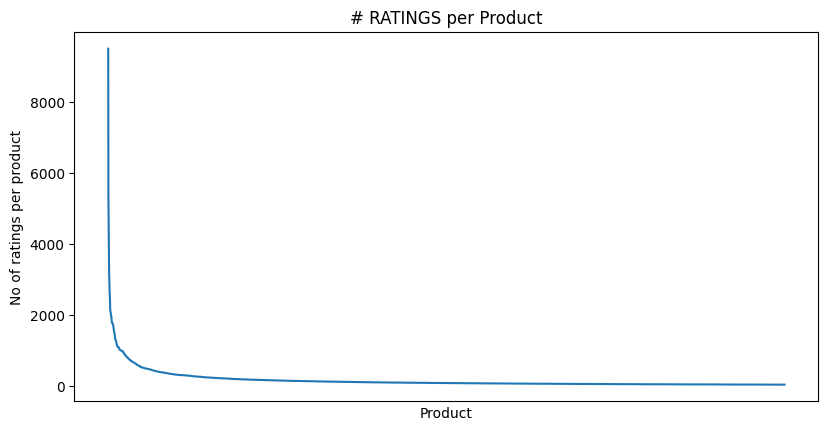

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.show()

In [ ]:
#Average rating of the product

new_df.groupby('productId')['Rating'].mean().head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


,Rating
productId,
B0000DYV9H,4.947368
B000053HC5,4.945783
B00009R96C,4.885714
B00005LE76,4.879310
B000I1X3W8,4.869565


In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

,Rating
productId,
B0002L5R78,9487
B0001FTVEK,5345
B000I68BD4,4903
B000BQ7GW8,4275
B00007E7JU,3523


In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [ ]:
ratings_mean_count['rating_counts'].max()


9487

<Figure size 800x600 with 0 Axes>

<Axes: >

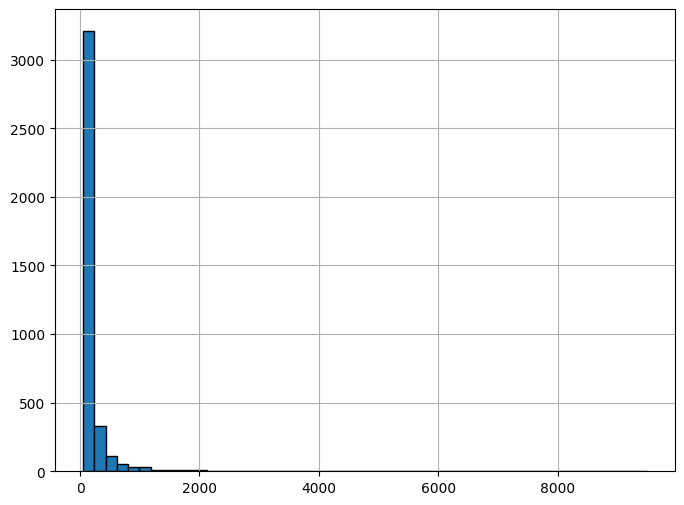

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

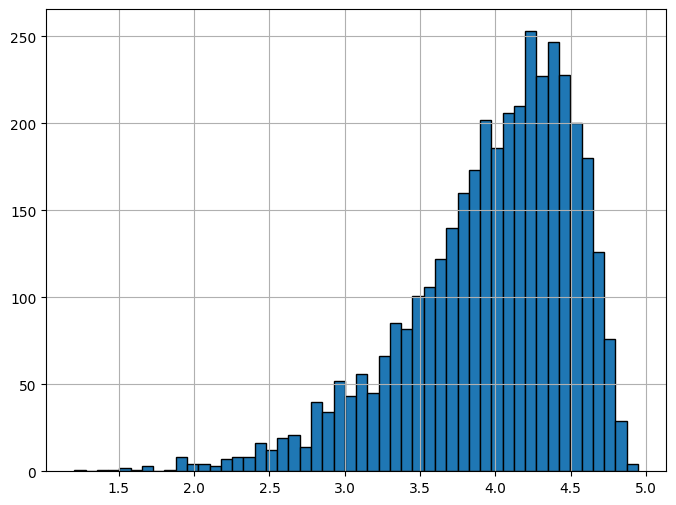

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

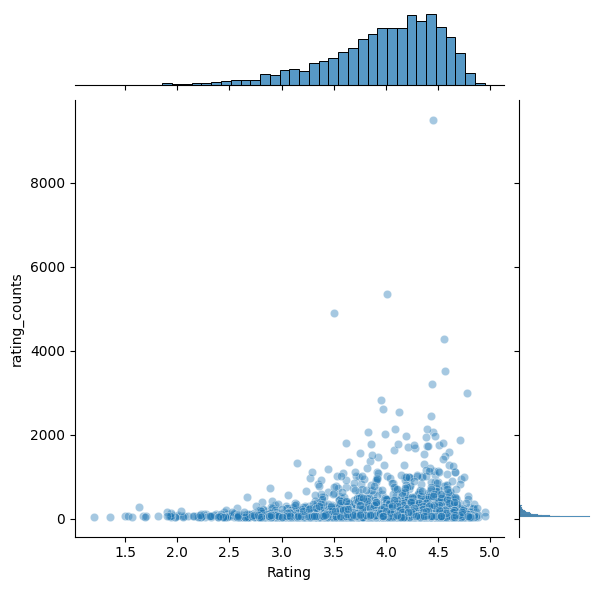

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

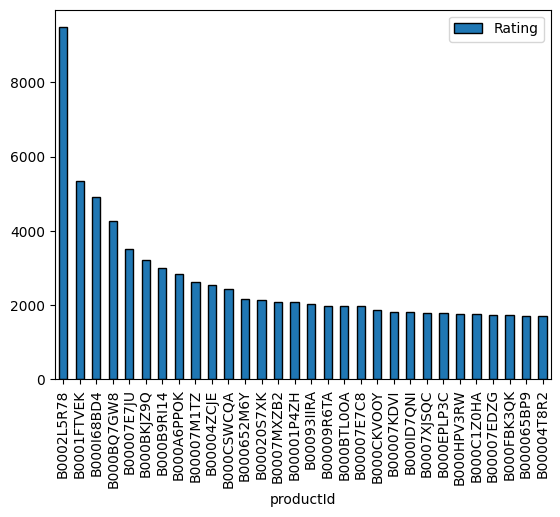

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357287 sha256=02072d6ae93ea5907b150eb8df3de57624246c270f109c58c616948b4c60723b
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred


[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

In [ ]:

new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0266076X6KPZ6CCHGVS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0293130VTX2ZXA70JQS,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A030530627MK66BD8V4LN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0571176384K8RBNKGF8O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [ ]:
ratings_matrix.shape


(9832, 76)

Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.shape


(76, 9832)

In [ ]:
X1 = X


In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
correlation_matrix = cosine_similarity(decomposed_matrix)

In [ ]:
X.index[75]


'B00000K135'

In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['6301977173',
 '8862935293',
 '9573212919',
 '9575871979',
 '9888002198',
 'B000001OM4',
 'B00000J08Q',
 'B00000J0D2',
 'B00000J0D5',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1TX',
 'B00000J1U8',
 'B00000J1UQ',
 'B00000J1V3',
 'B00000J3UJ',
 'B00000J4EY',
 'B00000J4GE',
 'B00000JBHP',
 'B00000JCTO',
 'B00000JD34',
 'B00000JFIF',
 'B00000JFMK']

Dataset Shape: (7824482, 4)
Data Types:
userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object
Rating Summary:
count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64
Missing Values:
userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


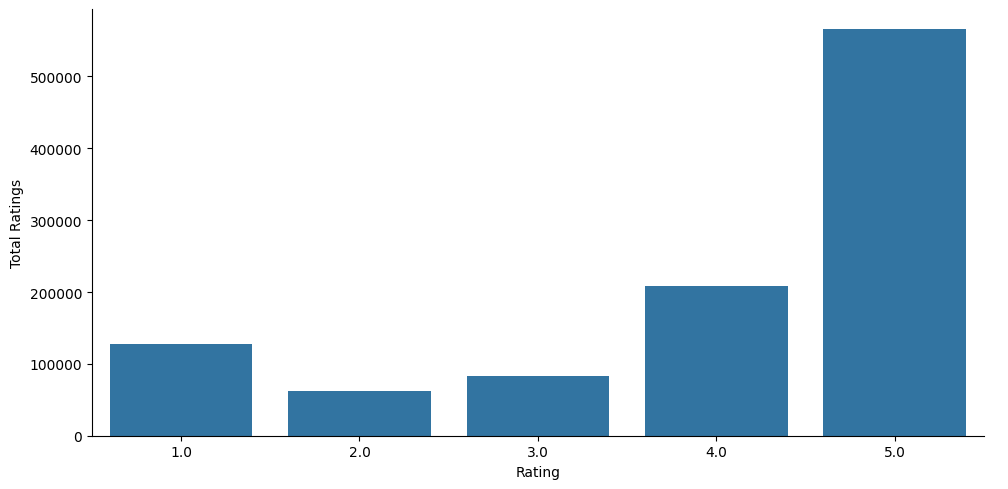

Total Ratings: 1048576
Total Unique Users: 786330
Total Unique Products: 61894
Top 5 Users by Number of Ratings:
userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64


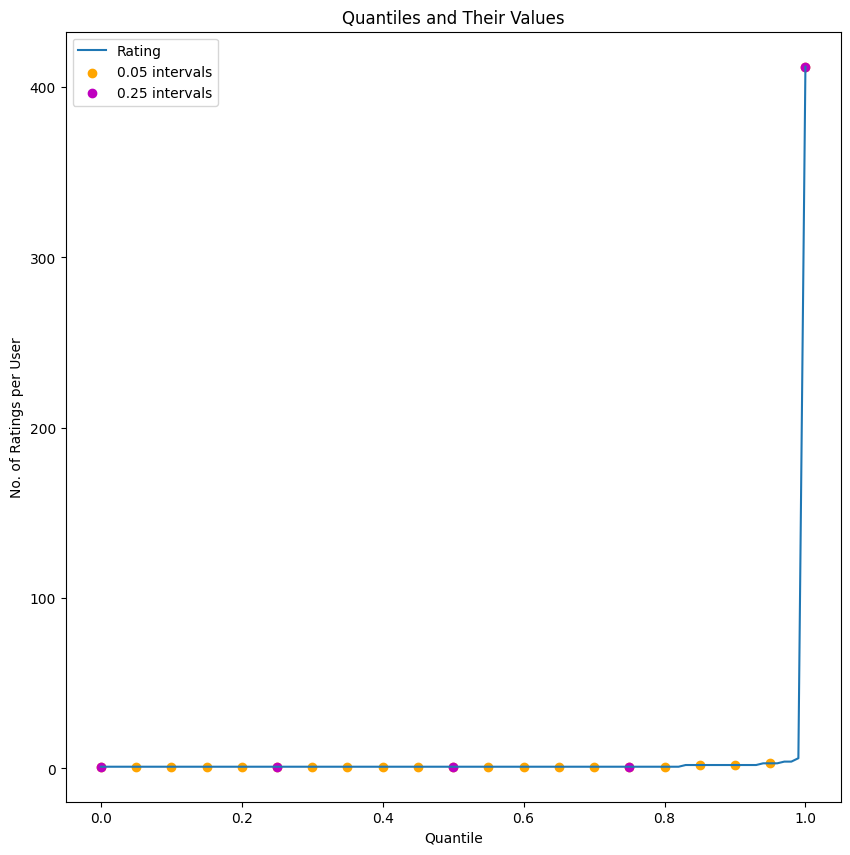

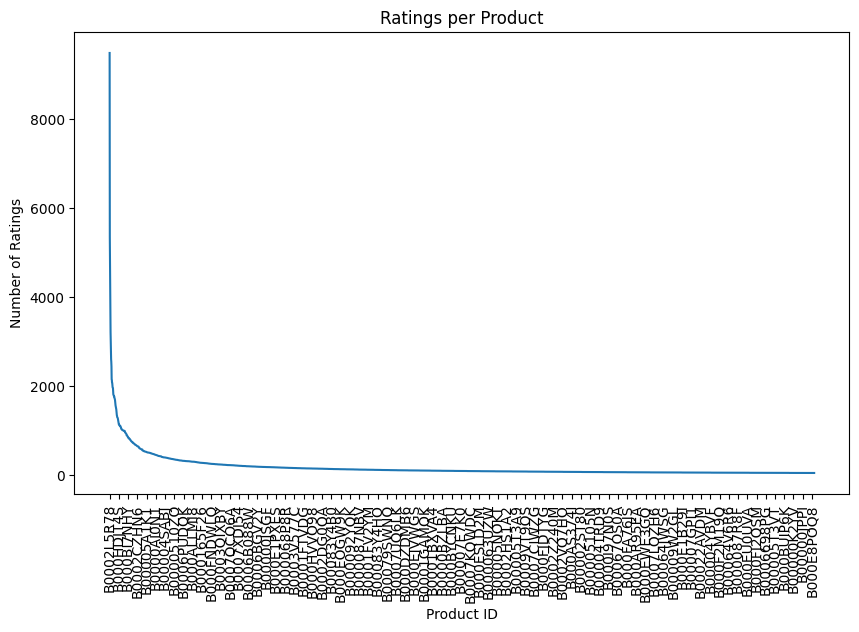

Top Products by Average Rating:
productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE for Item-Based Collaborative Filtering:
RMSE: 1.3438


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from surprise import KNNWithMeans, Dataset, accuracy, Reader
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings

# Suppress warnings for cleaner output
warnings.simplefilter('ignore')

# Configure Matplotlib for inline display
%matplotlib inline

# Load dataset (ensure proper path)
data_path = '/content/ratings_Electronics (1).csv'
electronics_df = pd.read_csv(data_path, names=['userId', 'productId', 'Rating', 'timestamp'])

# Display the first few rows of the dataset
electronics_df.head()

# Display the shape of the dataset
print(f"Dataset Shape: {electronics_df.shape}")

# Subset of data for performance optimization
electronics_df = electronics_df.iloc[:1048576, :]

# Check data types
print(f"Data Types:\n{electronics_df.dtypes}")

# Summary statistics
print(f"Rating Summary:\n{electronics_df.describe()['Rating'].T}")

# Check for missing values
print(f"Missing Values:\n{electronics_df.isnull().sum()}")

# Visualize rating distribution
sns.catplot(x="Rating", data=electronics_df, aspect=2.0, kind='count')
plt.ylabel("Total Ratings")
plt.show()

# Unique users and products in the dataset
unique_users = len(np.unique(electronics_df.userId))
unique_products = len(np.unique(electronics_df.productId))

print(f"Total Ratings: {electronics_df.shape[0]}")
print(f"Total Unique Users: {unique_users}")
print(f"Total Unique Products: {unique_products}")

# Drop unnecessary timestamp column
electronics_df.drop(['timestamp'], axis=1, inplace=True)

# Ratings analysis per user
user_ratings_count = electronics_df.groupby('userId')['Rating'].count().sort_values(ascending=False)
print(f"Top 5 Users by Number of Ratings:\n{user_ratings_count.head()}")

# Plot quantiles of ratings per user
quantiles = user_ratings_count.quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

plt.figure(figsize=(10, 10))
plt.title("Quantiles and Their Values")
quantiles.plot()
plt.scatter(quantiles.index[::5], quantiles.values[::5], c='orange', label="0.05 intervals")
plt.scatter(quantiles.index[::25], quantiles.values[::25], c='m', label="0.25 intervals")
plt.xlabel('Quantile')
plt.ylabel('No. of Ratings per User')
plt.legend(loc='best')
plt.show()

# Popularity-based recommendation: filter products with at least 50 ratings
popular_df = electronics_df.groupby('productId').filter(lambda x: x['Rating'].count() >= 50)
product_rating_count = popular_df.groupby('productId')['Rating'].count().sort_values(ascending=False)

# Plot ratings per product
plt.figure(figsize=(10, 6))
plt.plot(product_rating_count.values)
plt.title("Ratings per Product")
plt.xlabel("Product ID")
plt.ylabel("Number of Ratings")
plt.xticks(ticks=np.arange(0, len(product_rating_count), 50), labels=product_rating_count.index[::50], rotation=90)
plt.show()

# Average rating per product
avg_product_rating = popular_df.groupby('productId')['Rating'].mean().sort_values(ascending=False)
print(f"Top Products by Average Rating:\n{avg_product_rating.head()}")

# Item-based Collaborative Filtering using Surprise library

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(popular_df[['userId', 'productId', 'Rating']], reader)
# Import the required module from Surprise
from surprise.model_selection import train_test_split

# Split data into training and testing sets using Surprise's method
train_set, test_set = train_test_split(surprise_data, test_size=0.3, random_state=42)

# Train an Item-based collaborative filtering model
model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
model.fit(train_set)

# Test the model on the test set
predictions = model.test(test_set)

# Calculate and print RMSE
print("RMSE for Item-Based Collaborative Filtering:")
accuracy.rmse(predictions)

# Matrix Factorization using SVD (Singular Value Decomposition)

# Prepare the ratings matrix
ratings_matrix = popular_df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix_transposed = ratings_matrix.T

# Apply SVD
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(ratings_matrix_transposed)

# Cosine similarity matrix
cosine_sim = cosine_similarity(decomposed_matrix)

# Get product index for a given product ID
product_index = list(ratings_matrix_transposed.index).index("B00000K135")

# Find similar products
similar_products = cosine_sim[product_index]
recommended_products = ratings_matrix_transposed.index[similar_products > 0.65].tolist()

# Remove the original product from recommendations
recommended_products = [product for product in recommended_products if product != "B00000K135"]

# Display top 24 recommended products
print(f"Recommended Products for Product B00000K135:\n{recommended_products[:24]}")

Sample Data:
           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
Dataset Dimensions: (7824482, 4)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB
None

Summary Statistics for Ratings:
count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.00

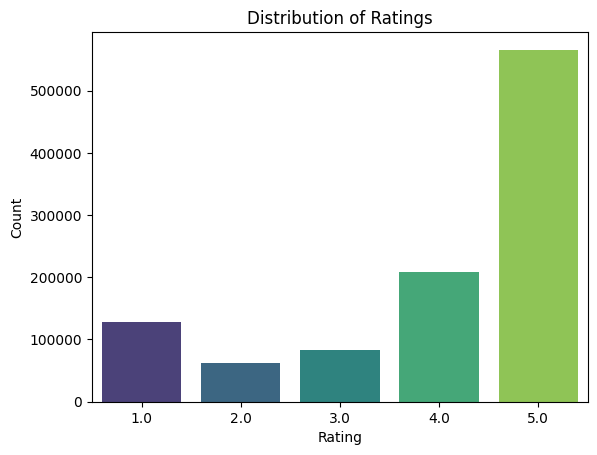


Total Ratings: 1048576
Unique Users: 786330
Unique Products: 61894

Top 5 Users with Most Ratings:
userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64


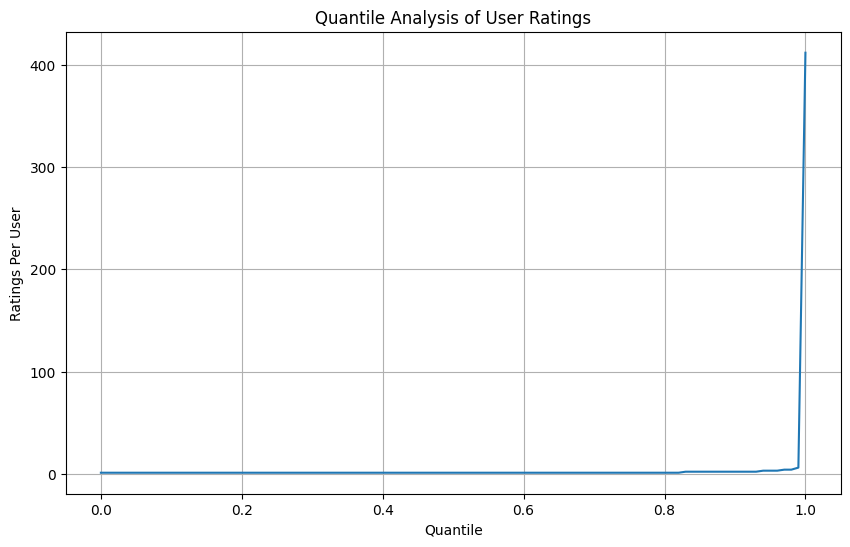

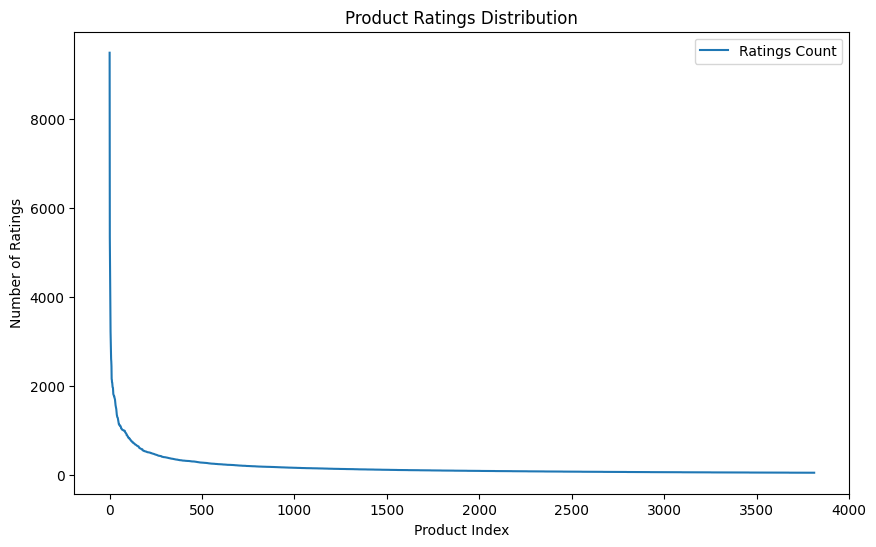


Top Products by Average Rating:
productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Collaborative Filtering Model Evaluation:
RMSE: 1.3438


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# Load the dataset
data_path = '/content/ratings_Electronics (1).csv'
electronics_df = pd.read_csv(data_path, names=['userId', 'productId', 'Rating', 'timestamp'])

# Initial data inspection
print("Sample Data:")
print(electronics_df.head())
print(f"Dataset Dimensions: {electronics_df.shape}")

# Limit dataset for faster computation
electronics_df = electronics_df.iloc[:1048576, :]

# Data Summary
print("\nDataset Information:")
print(electronics_df.info())
print("\nSummary Statistics for Ratings:")
print(electronics_df['Rating'].describe())

# Check for missing values
missing_values = electronics_df.isnull().sum()
print(f"\nMissing Values:\n{missing_values}")

# Visualize the distribution of ratings
sns.countplot(data=electronics_df, x='Rating', palette='viridis')
plt.title("Distribution of Ratings")
plt.ylabel("Count")
plt.show()

# Dataset details
unique_users = electronics_df['userId'].nunique()
unique_products = electronics_df['productId'].nunique()
print(f"\nTotal Ratings: {electronics_df.shape[0]}")
print(f"Unique Users: {unique_users}")
print(f"Unique Products: {unique_products}")

# Remove the timestamp column
electronics_df.drop(columns=['timestamp'], inplace=True)

# Analyzing user rating counts
user_rating_counts = electronics_df.groupby('userId')['Rating'].count()
print("\nTop 5 Users with Most Ratings:")
print(user_rating_counts.nlargest(5))

# Quantile analysis of user ratings
quantiles = user_rating_counts.quantile(np.arange(0, 1.01, 0.01))
plt.figure(figsize=(10, 6))
quantiles.plot()
plt.title("Quantile Analysis of User Ratings")
plt.xlabel("Quantile")
plt.ylabel("Ratings Per User")
plt.grid()
plt.show()

# Popularity-based recommendation system
popular_products = electronics_df.groupby('productId').filter(lambda x: x['Rating'].count() >= 50)
product_ratings_count = popular_products.groupby('productId')['Rating'].count().sort_values(ascending=False)

# Visualize ratings per product
plt.figure(figsize=(10, 6))
plt.plot(product_ratings_count.values, label='Ratings Count')
plt.title("Product Ratings Distribution")
plt.xlabel("Product Index")
plt.ylabel("Number of Ratings")
plt.legend()
plt.show()

# Average rating per product
average_product_ratings = popular_products.groupby('productId')['Rating'].mean().sort_values(ascending=False)
print("\nTop Products by Average Rating:")
print(average_product_ratings.head())

# Collaborative Filtering using Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(popular_products[['userId', 'productId', 'Rating']], reader)

# Splitting dataset
train_set, test_set = train_test_split(surprise_data, test_size=0.3, random_state=42)

# Train item-based collaborative filtering model
cf_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
cf_model.fit(train_set)

# Test the model
cf_predictions = cf_model.test(test_set)

# Evaluate performance
print("\nCollaborative Filtering Model Evaluation:")
accuracy.rmse(cf_predictions)

# Matrix factorization with SVD
ratings_matrix = popular_products.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix_t = ratings_matrix.T

# Apply SVD
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(ratings_matrix_t)

# Cosine similarity
cos_sim_matrix = cosine_similarity(svd_matrix)

# Recommendation for a specific product
target_product = "B00000K135"
product_idx = list(ratings_matrix_t.index).index(target_product)
similarity_scores = cos_sim_matrix[product_idx]
recommended_items = ratings_matrix_t.index[similarity_scores > 0.65].tolist()

# Exclude the target product from recommendations
if target_product in recommended_items:
    recommended_items.remove(target_product)

# Display recommendations
print(f"\nRecommendations for Product {target_product}:")
print(recommended_items[:24])


Sample Data:
           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
Dataset Dimensions: (7824482, 4)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB
None

Summary Statistics for Ratings:
count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.00

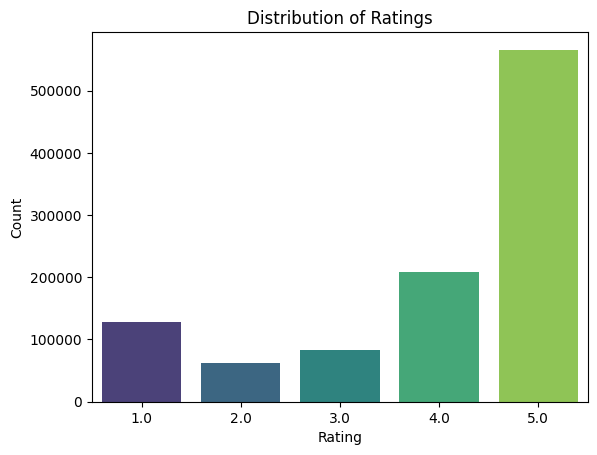


Total Ratings: 1048576
Unique Users: 786330
Unique Products: 61894

Top 5 Users with Most Ratings:
userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64


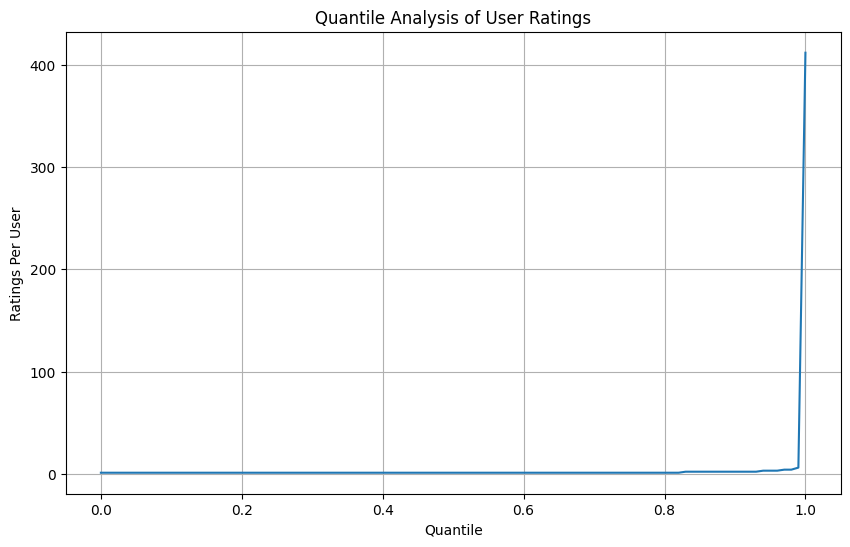

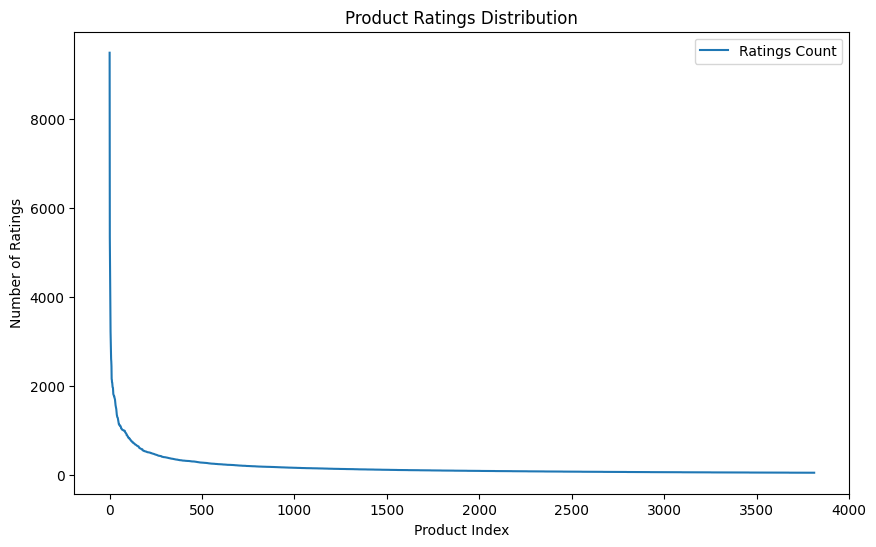


Top Products by Average Rating:
productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

Recommendations for New Users:

Top 10 Recommendations for New Users:
productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
B0002E52S4    4.861111
B000213ZFE    4.860000
B00006I53W    4.859551
B00005UKBD    4.858974
B0000TU7I6    4.855263
Name: Rating, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# Load the dataset
data_path = '/content/ratings_Electronics (1).csv'
electronics_df = pd.read_csv(data_path, names=['userId', 'productId', 'Rating', 'timestamp'])

# Initial data inspection
print("Sample Data:")
print(electronics_df.head())
print(f"Dataset Dimensions: {electronics_df.shape}")

# Limit dataset for faster computation
electronics_df = electronics_df.iloc[:1048576, :]

# Data Summary
print("\nDataset Information:")
print(electronics_df.info())
print("\nSummary Statistics for Ratings:")
print(electronics_df['Rating'].describe())

# Check for missing values
missing_values = electronics_df.isnull().sum()
print(f"\nMissing Values:\n{missing_values}")

# Visualize the distribution of ratings
sns.countplot(data=electronics_df, x='Rating', palette='viridis')
plt.title("Distribution of Ratings")
plt.ylabel("Count")
plt.show()

# Dataset details
unique_users = electronics_df['userId'].nunique()
unique_products = electronics_df['productId'].nunique()
print(f"\nTotal Ratings: {electronics_df.shape[0]}")
print(f"Unique Users: {unique_users}")
print(f"Unique Products: {unique_products}")

# Remove the timestamp column
electronics_df.drop(columns=['timestamp'], inplace=True)

# Analyzing user rating counts
user_rating_counts = electronics_df.groupby('userId')['Rating'].count()
print("\nTop 5 Users with Most Ratings:")
print(user_rating_counts.nlargest(5))

# Quantile analysis of user ratings
quantiles = user_rating_counts.quantile(np.arange(0, 1.01, 0.01))
plt.figure(figsize=(10, 6))
quantiles.plot()
plt.title("Quantile Analysis of User Ratings")
plt.xlabel("Quantile")
plt.ylabel("Ratings Per User")
plt.grid()
plt.show()

# Popularity-based recommendation system
popular_products = electronics_df.groupby('productId').filter(lambda x: x['Rating'].count() >= 50)
product_ratings_count = popular_products.groupby('productId')['Rating'].count().sort_values(ascending=False)

# Visualize ratings per product
plt.figure(figsize=(10, 6))
plt.plot(product_ratings_count.values, label='Ratings Count')
plt.title("Product Ratings Distribution")
plt.xlabel("Product Index")
plt.ylabel("Number of Ratings")
plt.legend()
plt.show()

# Average rating per product
average_product_ratings = popular_products.groupby('productId')['Rating'].mean().sort_values(ascending=False)
print("\nTop Products by Average Rating:")
print(average_product_ratings.head())

# Function to recommend products for new users (Cold Start Solution)
def recommend_for_new_user(n=10):
    # Recommend the top-n most popular products
    top_products = popular_products.groupby('productId')['Rating'].mean().sort_values(ascending=False)
    print(f"\nTop {n} Recommendations for New Users:")
    return top_products.head(n)

print("\nRecommendations for New Users:")
print(recommend_for_new_user(10))

# Metadata-based recommendations for new products
# Add dummy metadata for demonstration purposes
product_metadata = electronics_df[['productId']].drop_duplicates()
product_metadata['description'] = ["High quality electronics"] * len(product_metadata)  # Dummy descriptions

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_metadata['description'])

# Compute cosine similarity for metadata
metadata_similarity = cosine_similarity(tfidf_matrix)

def recommend_new_product(product_id, n=5):
    # Find index of the product
    product_idx = product_metadata[product_metadata['productId'] == product_id].index[0]
    similarity_scores = list(enumerate(metadata_similarity[product_idx]))
    # Sort and select top-n similar products
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    recommended_products = [product_metadata.iloc[i[0]]['productId'] for i in similar_products]
    return recommended_products

new_product_id = "B00000K135"  # Replace with a valid productId
print(f"\nRecommendations for New Product {new_product_id}:")
print(recommend_new_product(new_product_id, 5))

# Collaborative Filtering using Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(popular_products[['userId', 'productId', 'Rating']], reader)

# Splitting dataset
train_set, test_set = train_test_split(surprise_data, test_size=0.3, random_state=42)

# Train item-based collaborative filtering model
cf_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
cf_model.fit(train_set)

# Test the model
cf_predictions = cf_model.test(test_set)

# Evaluate performance
print("\nCollaborative Filtering Model Evaluation:")
accuracy.rmse(cf_predictions)

# Matrix factorization with SVD
ratings_matrix = popular_products.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix_t = ratings_matrix.T

# Apply SVD
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(ratings_matrix_t)

# Cosine similarity
cos_sim_matrix = cosine_similarity(svd_matrix)

# Recommendation for a specific product
target_product = "B00000K135"
if target_product in ratings_matrix_t.index:
    product_idx = list(ratings_matrix_t.index).index(target_product)
    similarity_scores = cos_sim_matrix[product_idx]
    recommended_items = ratings_matrix_t.index[similarity_scores > 0.65].tolist()
    if target_product in recommended_items:
        recommended_items.remove(target_product)
    print(f"\nRecommendations for Product {target_product}:")
    print(recommended_items[:10])
else:
    print(f"Product {target_product} not found in the dataset.")


Sample Data:
           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
Dataset Dimensions: (7824482, 4)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB
None

Summary Statistics for Ratings:
count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.00

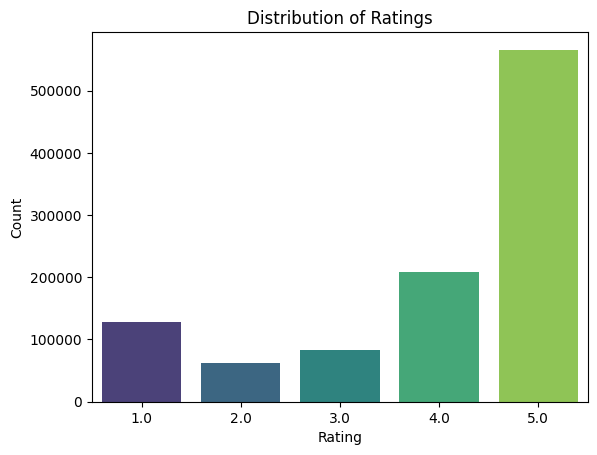


Total Ratings: 1048576
Unique Users: 786330
Unique Products: 61894

Top 5 Users with Most Ratings:
userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64


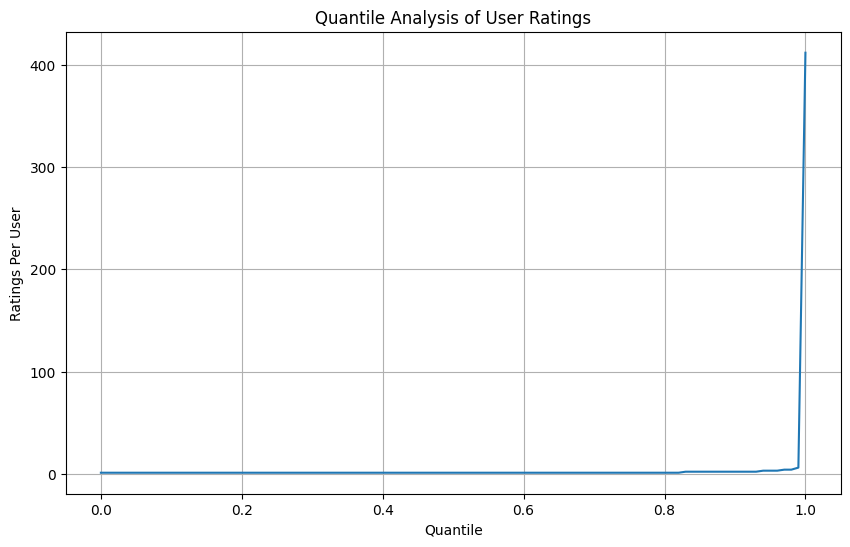

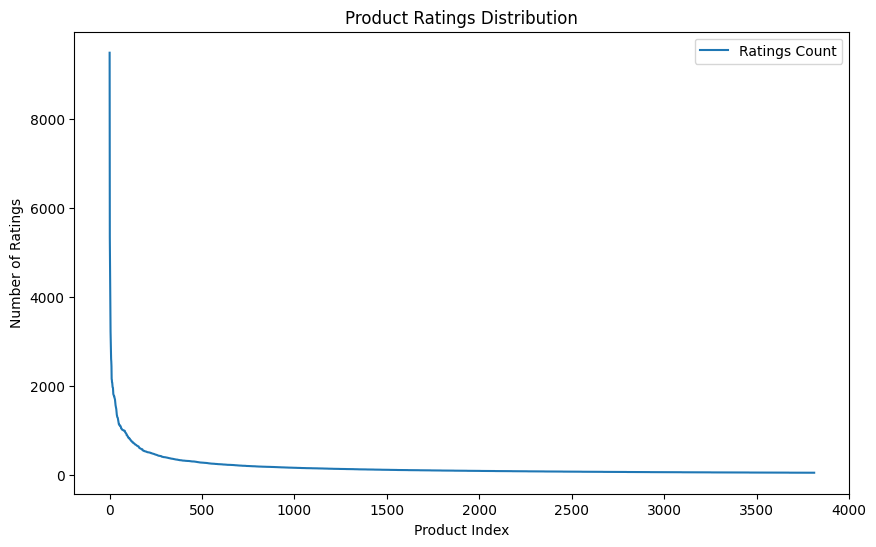


Top Products by Average Rating:
productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Collaborative Filtering Model Evaluation:
RMSE: 0.0095


In [ ]:
# -*- coding: utf-8 -*-
"""Recommender System Using Amazon Reviews"""

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader, KNNWithMeans, accuracy
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load the dataset
data_path = '/content/ratings_Electronics (1).csv'
electronics_df = pd.read_csv(data_path, names=['userId', 'productId', 'Rating', 'timestamp'])

# Initial data inspection
print("Sample Data:")
print(electronics_df.head())
print(f"Dataset Dimensions: {electronics_df.shape}")

# Limit dataset for faster computation
electronics_df = electronics_df.iloc[:1048576, :]

# Data Summary
print("\nDataset Information:")
print(electronics_df.info())
print("\nSummary Statistics for Ratings:")
print(electronics_df['Rating'].describe())

# Check for missing values
missing_values = electronics_df.isnull().sum()
print(f"\nMissing Values:\n{missing_values}")

# Visualize the distribution of ratings
sns.countplot(data=electronics_df, x='Rating', palette='viridis')
plt.title("Distribution of Ratings")
plt.ylabel("Count")
plt.show()

# Dataset details
unique_users = electronics_df['userId'].nunique()
unique_products = electronics_df['productId'].nunique()
print(f"\nTotal Ratings: {electronics_df.shape[0]}")
print(f"Unique Users: {unique_users}")
print(f"Unique Products: {unique_products}")

# Remove the timestamp column
electronics_df.drop(columns=['timestamp'], inplace=True)

# Analyzing user rating counts
user_rating_counts = electronics_df.groupby('userId')['Rating'].count()
print("\nTop 5 Users with Most Ratings:")
print(user_rating_counts.nlargest(5))

# Quantile analysis of user ratings
quantiles = user_rating_counts.quantile(np.arange(0, 1.01, 0.01))
plt.figure(figsize=(10, 6))
quantiles.plot()
plt.title("Quantile Analysis of User Ratings")
plt.xlabel("Quantile")
plt.ylabel("Ratings Per User")
plt.grid()
plt.show()

# Popularity-based recommendation system
popular_products = electronics_df.groupby('productId').filter(lambda x: x['Rating'].count() >= 50)
product_ratings_count = popular_products.groupby('productId')['Rating'].count().sort_values(ascending=False)

# Visualize ratings per product
plt.figure(figsize=(10, 6))
plt.plot(product_ratings_count.values, label='Ratings Count')
plt.title("Product Ratings Distribution")
plt.xlabel("Product Index")
plt.ylabel("Number of Ratings")
plt.legend()
plt.show()

# Average rating per product
average_product_ratings = popular_products.groupby('productId')['Rating'].mean().sort_values(ascending=False)
print("\nTop Products by Average Rating:")
print(average_product_ratings.head())
# Collaborative Filtering using Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(popular_products[['userId', 'productId', 'Rating']], reader)

# Splitting dataset using Surprise's method
train_set, test_set = surprise_data.build_full_trainset(), surprise_data.construct_testset(surprise_data.raw_ratings)

# Train item-based collaborative filtering model
cf_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
cf_model.fit(train_set)

# Test the model on the test set
cf_predictions = cf_model.test(test_set)

# Evaluate performance
print("\nCollaborative Filtering Model Evaluation:")
accuracy.rmse(cf_predictions)

# Matrix factorization with SVD
ratings_matrix = popular_products.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix_t = ratings_matrix.T

# Apply SVD
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(ratings_matrix_t)

# Cosine similarity
cos_sim_matrix = cosine_similarity(svd_matrix)

# Recommendation for a specific product
target_product = "B00000K135"  # Replace with a valid productId
if target_product in ratings_matrix_t.index:
    product_idx = list(ratings_matrix_t.index).index(target_product)
    similarity_scores = cos_sim_matrix[product_idx]
    recommended_items = ratings_matrix_t.index[similarity_scores > 0.65].tolist()
    if target_product in recommended_items:
        recommended_items.remove(target_product)
    print(f"\ nRecommendations for Product {target_product}:")
    print(recommended_items[:10])
else:
    print(f"Product {target_product} not found in the dataset.")

# Function to recommend products for new users (Cold Start Solution)
def recommend_for_new_user(n=10):
    # Recommend the top-n most popular products
    top_products = popular_products.groupby('productId')['Rating'].mean().sort_values(ascending=False)
    print(f"\nTop {n} Recommendations for New Users:")
    return top_products.head(n)

print("\nRecommendations for New Users:")
print(recommend_for_new_user(10))

# Metadata-based recommendations for new products
# Add dummy metadata for demonstration purposes
product_metadata = electronics_df[['productId']].drop_duplicates()
product_metadata['description'] = ["High quality electronics"] * len(product_metadata)  # Dummy descriptions

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_metadata['description'])

# Compute cosine similarity for metadata
metadata_similarity = cosine_similarity(tfidf_matrix)

def recommend_new_product(product_id, n=5):
    # Find index of the product
    product_idx = product_metadata[product_metadata['productId'] == product_id].index[0]
    similarity_scores = list(enumerate(metadata_similarity[product_idx]))
    # Sort and select top-n similar products
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    recommended_products = [product_metadata.iloc[i[0]]['productId'] for i in similar_products]
    return recommended_products

new_product_id = "B00000K135"  # Replace with a valid productId
print(f"\nRecommendations for New Product {new_product_id}:")
print(recommend_new_product(new_product_id, 5))